## Classification

Scikit-Learn provides many helper functions to download popular datasets. MNIST ("Modified National Institute of Standards and Technology") is one of them. The MNIST database is a large database of handwritten digits that is commonly used for training various image processing systems.

Let’s look at these arrays:

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s imshow() function:

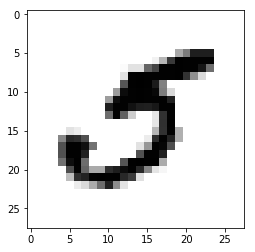

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Try to use some other index like 26000
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")

#Try to switch off the axis
#plt.axis("off")
plt.show()

In [5]:
y[36000]

5.0

We should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):


In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


#Try to split test and train data by 65000, or 69000 and observe the errors

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen:2

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [8]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

#Try to model for all 4s or 2s

Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

Difference between batch and SGD:
https://stats.stackexchange.com/questions/49528/batch-gradient-descent-versus-stochastic-gradient-descent
https://towardsdatascience.com/difference-between-batch-gradient-descent-and-stochastic-gradient-descent-1187f1291aa1 


In [9]:
from sklearn.linear_model import SGDClassifier

# Try changing max_iter to 25, 50, 75, 125 and observe execution time and accuracy

sgd_clf = SGDClassifier( max_iter=100, tol=None)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

Now you can use it to detect images of the number 5:

In [10]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# Try with cv=4

array([ 0.96585,  0.96505,  0.96635])

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53726,   853],
       [ 1150,  4271]])

In [14]:
## see if we assign training data to predicted values
# y_train_perfect_predictions = y_train_5
# confusion_matrix(y_train_5, y_train_perfect_predictions)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 54,174 of them were correctly classified as non-5s (they are called true negatives), while the remaining 405 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,931 were wrongly classified as non-5s (false negatives), while the remaining 3,490 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

### Precision = TP / (TP + FP)

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.83352849336455892

### Recall = TP / (TP + FN)

In [16]:
recall_score(y_train_5, y_train_pred)

0.78786201807784539

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
0.78468208092485547

0.7846820809248555

Links:
* https://machinelearningmastery.com/confusion-matrix-machine-learning/
* https://en.wikipedia.org/wiki/Precision_and_recall